In [126]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

import pycaret

### AutoML/Hyperparameter Tuning

Given the nature of this project as wholly unsupervised, clustering and anomaly detection are the only real models that can be run on our data. Accuracy cannot be evaluated on unlabeled data, but computational time and interpretability can be.<br> <br>

To that end, this notebook using PyCaret optimally cluster the data and identify outliers.

#### Data Note

This analysis was originally attempted with spectrogram data, as is done in Zali et al., but to poor results here using simpler machine learning methods. For the purpose of exploring AutoML, statistics on the data were computed and used in place of the raw spectra

In [36]:
#read in spectras file to dataframe
filepath = os.getcwd() + '/data/ai_ready/'
# filename = 'spectra.npy'
# df = pd.DataFrame(np.load(filepath+filename))
filename = 'statistics.csv'
df = pd.read_csv(filepath+filename)
df.head()

,mean,max,min,median,range,std,spec_mean,spec_max,spec_min,spec_median,spec_range,spec_std
0,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.004337,0.153382,7.070107e-07,0.000710,0.153382,0.010231
1,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003954,0.150999,1.275567e-06,0.000715,0.150998,0.008960
2,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003816,0.177869,2.608655e-06,0.000687,0.177866,0.008829
3,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.004417,0.323616,6.022107e-07,0.000681,0.323615,0.012174
4,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003979,0.139368,5.308308e-07,0.000616,0.139368,0.009023


In [37]:
# import pycaret clustering and init setup
from pycaret.clustering import *
s = setup(df, session_id = 120)

,Description,Value
0,Session id,120
1,Original data shape,"(2400, 12)"
2,Transformed data shape,"(2400, 12)"
3,Numeric features,12
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [38]:
# import ClusteringExperiment and init the class
from pycaret.clustering import ClusteringExperiment
exp = ClusteringExperiment()

# check the type of exp
type(exp)

pycaret.clustering.oop.ClusteringExperiment

In [39]:
# init setup on exp
exp.setup(df, session_id = 120)

,Description,Value
0,Session id,120
1,Original data shape,"(2400, 12)"
2,Transformed data shape,"(2400, 12)"
3,Numeric features,12
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


### Create Model

Trains and evaluates a given model

In [40]:
#check all available models
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch


In [143]:
#train kmeans model
aggl = create_model('hclust')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3149,1121.6542,0.8878,0,0,0


### Assign Model
Actually assign labels using a given clustering model

In [145]:
aggl_cluster = assign_model(aggl)
aggl_cluster.Cluster

0       Cluster 0
1       Cluster 0
2       Cluster 0
3       Cluster 0
4       Cluster 0
          ...    
2395    Cluster 2
2396    Cluster 2
2397    Cluster 2
2398    Cluster 2
2399    Cluster 2
Name: Cluster, Length: 2400, dtype: object

In [147]:
#see how many clusters were chosen
len(np.unique(aggl_cluster.Cluster))

4

### Visualize Model

In [148]:
plot_model(aggl, plot = 'cluster')

### Plot Elbow Curve for Clustering

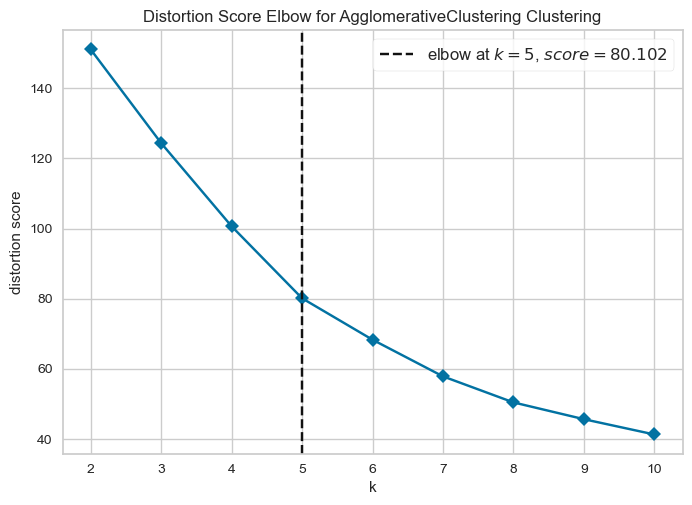

In [149]:
plot_model(aggl, plot = 'elbow')

### Plot Silhoutte

Only seems to work for kmeans model. This appears to be a bug with this version of pycaret, as other models have silhouette scores.

In [152]:
#plot_model(kmeans, plot = 'silhouette')

### Now Run for All Model Options and Compare Performance

In [77]:
model_list = ['kmeans', 'ap', 'meanshift', 'sc', 'hclust', 'dbscan', 'optics', 'birch']

### Brief Description of the Algorithms Tested
K-Means Clustering : Minimizes the distance of the data points relative to a given number of centroids <br><br>

Affinity Propagation : Clusters points based on a similarity function, requires a set number of clusters and eigenvectors to use. <br><br>

Mean Shift Clustering : Seeks to group data according to maximas in an underlying density function. Does not require a present cluster number. <br><br>

Spectral Clustering : Uses the eigenvectors of the data's similarity matrix to reduce the data's dimension and then k-means clustering. <br><br>

Agglomerative Clustering : Begins with each point as it's own cluster, and progressively merges clusters to maximize the distance between clusters.<br><br>

DBSCAN : Forms clusters by separating areas of low and high density, two parameters must be set to decide what is considered 'dense'. <br><br>

OPTICS : Is similar to DBSCAN, but can have a less rigid definition of density.<br><br>

BIRCH : Clusters by first performing extreme dimensionality reduction to the data, and incrementally adding complexity back in until given, threshold, branching, and cluster number parameters are met.

In [130]:
performance_df = pd.DataFrame(columns=["Silhouette",'Calinski-Harabasz','Davies-Bouldin',
                                       'Homogeneity','Rand Index', 'Completeness'])

#create list to store compute time
times = []

for model in model_list:
    time1 = time.time()
    create_model(model)
    time2 = time.time()
    dtime = time2 - time1
    times.append(dtime)

    performance_df.loc[len(performance_df)] = pull().to_numpy()[0]

performance_df['Model'] = model_list
performance_df['Time'] = times

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3994,1637.5477,0.8706,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2587,249.7507,0.6476,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3873,1464.9151,0.9241,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3149,1121.6542,0.8878,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0976,19.3250,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


In [131]:
performance_df

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,Model,Time
0,0.3994,1637.5477,0.8706,0.0,0.0,0.0,kmeans,0.377512
1,0.2587,249.7507,0.6476,0.0,0.0,0.0,ap,9.775017
2,0.0000,0.0000,0.0000,0.0,0.0,0.0,meanshift,3.302260
3,0.3873,1464.9151,0.9241,0.0,0.0,0.0,sc,0.719443
4,0.3149,1121.6542,0.8878,0.0,0.0,0.0,hclust,0.527781
5,0.0000,0.0000,0.0000,0.0,0.0,0.0,dbscan,0.309375
6,0.0976,19.3250,1.2250,0.0,0.0,0.0,optics,35.141843
7,0.0000,0.0000,0.0000,0.0,0.0,0.0,birch,0.291642


### Results

The best performing clustering model is Kmeans, the least exotic of the 8. It produces the highest Silhouette score, which measures the similarity of the points to their assigned clusters vs the other clusters. Spectral Clustering and Agglomerative Clustering also performed well, but were outperformed by Kmeans in all nonzero metrics, including time. The Davies-Bouldin index indicates better clustering at lower values. <br>br>

With its good clustering performance, Kmeans is also the second fastest model tested, running in around a third of a second, compared to OPTICS 30+ seconds. <br><br>

PyCaret, for Kmeans, only has to search for a single ideal hyperparameter, the number of clusters.